In [21]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import random
import glob
import cv2
import os
from torchvision.models.video import r3d_18
import torchvision
import ast

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else cpu)

In [3]:
csv_path = '/content/drive/MyDrive/Batch01/mafat_sniffing_batch01.csv'

video_dir = '/content/drive/MyDrive/Batch01/videos'

frames_dir = '/content/data/frames/'

behavior_to_class = {
    'Sniff bin 1': 'data/sniffing/bin1/',
    'Sniff bin 2': 'data/sniffing/bin2/',
    'Sniff bin 3': 'data/sniffing/bin3/',
    'Alert': 'data/alert/'
}

os.makedirs(frames_dir, exist_ok=True)

In [4]:
for dir_path in behavior_to_class.values():
  os.makedirs(dir_path, exist_ok=True)

df = pd.read_csv(csv_path)
frame_data = []

In [5]:
df['frames'] = df['Media file name'].apply(lambda x: x.split('/')[-1])

grouped_by_video = df.groupby('frames')

frame_data = []

for video_name, group in tqdm(grouped_by_video, desc="video processing"):
    video_path = os.path.join(video_dir, video_name)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Can`t open: {video_path}")
        continue

    frames_to_extract = {}
    for _, row in group.iterrows():
        behavior = row['Behavior']
        if behavior in behavior_to_class:
            class_label = behavior_to_class[behavior]
            start_frame = int(row['Image index start'])
            stop_frame = int(row['Image index stop'])
            for i in range(start_frame, stop_frame + 1):
                frames_to_extract[i] = class_label

    current_frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if current_frame_idx in frames_to_extract:
            class_label = frames_to_extract[current_frame_idx]

            frame_filename = f"{video_name}_frame_{current_frame_idx}.jpg"
            frame_path = os.path.join(frames_dir, frame_filename)
            cv2.imwrite(frame_path, frame)

            frame_data.append([frame_path, class_label])

        current_frame_idx += 1

    cap.release()

print("Finish.")

video processing: 100%|██████████| 50/50 [07:57<00:00,  9.55s/it]

Finish.


In [6]:
output_df = pd.DataFrame(frame_data, columns=['frames', 'label'])

output_csv_path = '/content/data/output.csv'
output_df.to_csv(output_csv_path, index=False)

In [7]:
data_df = pd.read_csv('/content/data/output.csv')

sequences = []
current_sequence = []
current_label = None

for _, row in data_df.iterrows():
    frame_path = row["frames"]
    label = row["label"]
    if label != current_label and current_label is not None:
        if current_sequence:
            sequences.append((current_sequence, current_label))
        current_sequence = []
    current_sequence.append(frame_path)
    current_label = label

if current_sequence:
    sequences.append((current_sequence, current_label))

print(len(sequences))

250


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [11]:
labels = [seq[1] for seq in sequences]

train_data, temp_data = train_test_split(sequences, test_size=0.3, random_state=42, stratify=labels)
valid_data, test_data = train_test_split(temp_data, test_size=0.3, random_state=42, stratify=[seq[1] for seq in temp_data])

print(len(train_data))
print(len(valid_data))
print(len(test_data))

175
52
23


In [12]:
class VideoSequenceDataset(Dataset):
    def __init__(self, sequences, transform=None, num_frames=16):
        self.sequences = sequences
        self.transform = transform
        self.num_frames = num_frames
        self.labels = sorted(list(set([seq[1] for seq in sequences])))
        self.labels_to_idx = {cls: i for i, cls in enumerate(self.labels)}

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        frames, label_str = self.sequences[idx]
        label_idx = self.labels_to_idx[label_str]

        if len(frames) >= self.num_frames:
            indices = np.linspace(0, len(frames) - 1, self.num_frames, dtype=int)
            selected_frames = [frames[i] for i in indices]
        else:
            selected_frames = frames + [frames[-1]] * (self.num_frames - len(frames))

        images = [Image.open(frame).convert("RGB") for frame in selected_frames]

        if self.transform:
            images = [self.transform(img) for img in images]

        return torch.stack(images), torch.tensor(label_idx)

train_dataset = VideoSequenceDataset(train_data, transform=train_transform, num_frames=8)
valid_dataset = VideoSequenceDataset(valid_data, transform=train_transform, num_frames=8)
test_dataset = VideoSequenceDataset(test_data, transform=transform, num_frames=8)

In [15]:
frames, label = train_dataset[0]
print(frames.shape)
print(label)

torch.Size([8, 3, 224, 224])
tensor(3)


In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

for batch in train_dataloader:
  frames, labels = batch
  print(frames.shape)
  print(labels)
  break

torch.Size([8, 8, 3, 224, 224])
tensor([3, 0, 3, 1, 2, 3, 0, 0])


In [17]:
class CNN_LSTM(nn.Module):
  def __init__(self, num_classes, hidden_size=256, num_layers=1):
    super(CNN_LSTM, self).__init__()

    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    resnet.fc = nn.Identity()

    self.cnn = resnet
    self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    batch_size, seq_len, C, H, W = x.shape

    x = x.view(batch_size * seq_len, C, H, W)
    x = self.cnn(x)
    x = x.view(batch_size, seq_len, -1)
    x, _ = self.lstm(x)
    x = x[:, -1, :]
    x = self.fc(x)

    return x

model = CNN_LSTM(num_classes=4).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.9MB/s]


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

In [19]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [20]:
num_epochs = 30
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for frames, labels in train_loop:
        frames, labels = frames.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(frames)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        train_loop.set_postfix(loss=loss.item(), accuracy=100 * train_correct / train_total)

    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * train_correct / train_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    torch.cuda.empty_cache()

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for frames, labels in valid_dataloader:
            frames, labels = frames.to(device), labels.to(device)
            with autocast():
                outputs = model(frames)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(valid_dataloader)
    val_accuracy = 100 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss)
    lr = scheduler.get_last_lr()

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

/tmp/ipython-input-20-2471055486.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipython-input-20-2471055486.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, accuracy=40.6, loss=1.42]
/tmp/ipython-input-20-2471055486.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/30: Train Loss: 1.3097, Train Acc: 40.57% | Val Loss: 1.0076, Val Acc: 67.31%


Epoch 2/30: 100%|██████████| 22/22 [00:20<00:00,  1.10it/s, accuracy=64, loss=0.698]


Epoch 2/30: Train Loss: 0.9104, Train Acc: 64.00% | Val Loss: 0.8106, Val Acc: 65.38%


Epoch 3/30: 100%|██████████| 22/22 [00:20<00:00,  1.07it/s, accuracy=83.4, loss=0.661]


Epoch 3/30: Train Loss: 0.5753, Train Acc: 83.43% | Val Loss: 0.7721, Val Acc: 73.08%


Epoch 4/30: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s, accuracy=92.6, loss=0.633]


Epoch 4/30: Train Loss: 0.3148, Train Acc: 92.57% | Val Loss: 0.6413, Val Acc: 76.92%


Epoch 5/30: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it, accuracy=92.6, loss=0.166]


Epoch 5/30: Train Loss: 0.2612, Train Acc: 92.57% | Val Loss: 0.4264, Val Acc: 84.62%


Epoch 6/30: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s, accuracy=96.6, loss=0.0397]


Epoch 6/30: Train Loss: 0.1276, Train Acc: 96.57% | Val Loss: 0.6167, Val Acc: 82.69%


Epoch 7/30: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s, accuracy=97.7, loss=0.199]


Epoch 7/30: Train Loss: 0.0995, Train Acc: 97.71% | Val Loss: 0.4027, Val Acc: 84.62%


Epoch 8/30: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s, accuracy=100, loss=0.0637]


Epoch 8/30: Train Loss: 0.0683, Train Acc: 100.00% | Val Loss: 0.5516, Val Acc: 84.62%


Epoch 9/30: 100%|██████████| 22/22 [00:20<00:00,  1.09it/s, accuracy=97.7, loss=0.0736]


Epoch 9/30: Train Loss: 0.1082, Train Acc: 97.71% | Val Loss: 0.4029, Val Acc: 88.46%


Epoch 10/30: 100%|██████████| 22/22 [00:19<00:00,  1.13it/s, accuracy=100, loss=0.0317]


Epoch 10/30: Train Loss: 0.0401, Train Acc: 100.00% | Val Loss: 0.3775, Val Acc: 90.38%


Epoch 11/30: 100%|██████████| 22/22 [00:19<00:00,  1.12it/s, accuracy=99.4, loss=0.0249]


Epoch 11/30: Train Loss: 0.0517, Train Acc: 99.43% | Val Loss: 0.4329, Val Acc: 86.54%


Epoch 12/30: 100%|██████████| 22/22 [00:19<00:00,  1.13it/s, accuracy=100, loss=0.0132]


Epoch 12/30: Train Loss: 0.0289, Train Acc: 100.00% | Val Loss: 0.3739, Val Acc: 86.54%


Epoch 13/30: 100%|██████████| 22/22 [00:20<00:00,  1.07it/s, accuracy=99.4, loss=0.0195]


Epoch 13/30: Train Loss: 0.0357, Train Acc: 99.43% | Val Loss: 0.3598, Val Acc: 84.62%


Epoch 14/30: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s, accuracy=98.9, loss=0.0194]


Epoch 14/30: Train Loss: 0.0518, Train Acc: 98.86% | Val Loss: 0.3202, Val Acc: 88.46%


Epoch 15/30: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s, accuracy=100, loss=0.0411]


Epoch 15/30: Train Loss: 0.0236, Train Acc: 100.00% | Val Loss: 0.3222, Val Acc: 90.38%


Epoch 16/30: 100%|██████████| 22/22 [00:20<00:00,  1.05it/s, accuracy=99.4, loss=0.0228]


Epoch 16/30: Train Loss: 0.0256, Train Acc: 99.43% | Val Loss: 0.3091, Val Acc: 90.38%


Epoch 17/30: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s, accuracy=100, loss=0.0305]


Epoch 17/30: Train Loss: 0.0246, Train Acc: 100.00% | Val Loss: 0.3763, Val Acc: 88.46%


Epoch 18/30: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s, accuracy=100, loss=0.0156]


Epoch 18/30: Train Loss: 0.0229, Train Acc: 100.00% | Val Loss: 0.3741, Val Acc: 88.46%


Epoch 19/30: 100%|██████████| 22/22 [00:19<00:00,  1.13it/s, accuracy=100, loss=0.0116]


Epoch 19/30: Train Loss: 0.0225, Train Acc: 100.00% | Val Loss: 0.3638, Val Acc: 88.46%


Epoch 20/30: 100%|██████████| 22/22 [00:19<00:00,  1.12it/s, accuracy=100, loss=0.0171]


Epoch 20/30: Train Loss: 0.0201, Train Acc: 100.00% | Val Loss: 0.3963, Val Acc: 88.46%


Epoch 21/30: 100%|██████████| 22/22 [00:19<00:00,  1.12it/s, accuracy=99.4, loss=0.0341]


Epoch 21/30: Train Loss: 0.0306, Train Acc: 99.43% | Val Loss: 0.3813, Val Acc: 90.38%


Epoch 22/30: 100%|██████████| 22/22 [00:19<00:00,  1.13it/s, accuracy=98.3, loss=0.0124]


Epoch 22/30: Train Loss: 0.0376, Train Acc: 98.29% | Val Loss: 0.4047, Val Acc: 88.46%


Epoch 23/30: 100%|██████████| 22/22 [00:20<00:00,  1.07it/s, accuracy=100, loss=0.0185]


Epoch 23/30: Train Loss: 0.0255, Train Acc: 100.00% | Val Loss: 0.4131, Val Acc: 86.54%


Epoch 24/30: 100%|██████████| 22/22 [00:20<00:00,  1.05it/s, accuracy=100, loss=0.0141]


Epoch 24/30: Train Loss: 0.0278, Train Acc: 100.00% | Val Loss: 0.3933, Val Acc: 86.54%


Epoch 25/30: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s, accuracy=100, loss=0.0108]


Epoch 25/30: Train Loss: 0.0212, Train Acc: 100.00% | Val Loss: 0.3736, Val Acc: 88.46%


Epoch 26/30: 100%|██████████| 22/22 [00:21<00:00,  1.03it/s, accuracy=100, loss=0.0111]


Epoch 26/30: Train Loss: 0.0228, Train Acc: 100.00% | Val Loss: 0.4212, Val Acc: 86.54%


Epoch 27/30: 100%|██████████| 22/22 [00:21<00:00,  1.05it/s, accuracy=100, loss=0.0142]


Epoch 27/30: Train Loss: 0.0154, Train Acc: 100.00% | Val Loss: 0.4263, Val Acc: 84.62%


Epoch 28/30: 100%|██████████| 22/22 [00:20<00:00,  1.07it/s, accuracy=100, loss=0.0147]


Epoch 28/30: Train Loss: 0.0159, Train Acc: 100.00% | Val Loss: 0.3690, Val Acc: 88.46%


Epoch 29/30: 100%|██████████| 22/22 [00:20<00:00,  1.09it/s, accuracy=99.4, loss=0.0496]


Epoch 29/30: Train Loss: 0.0282, Train Acc: 99.43% | Val Loss: 0.3980, Val Acc: 88.46%


Epoch 30/30: 100%|██████████| 22/22 [00:19<00:00,  1.11it/s, accuracy=100, loss=0.00983]


Epoch 30/30: Train Loss: 0.0202, Train Acc: 100.00% | Val Loss: 0.3781, Val Acc: 88.46%


Text(0.5, 1.0, 'Training and Validation Loss')

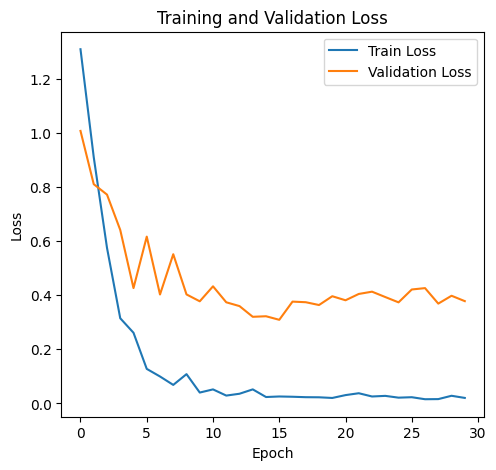

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

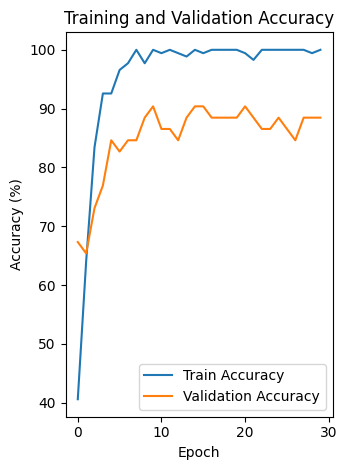

In [23]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [26]:
def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for frames, labels in test_loader:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    accuracy = 100 * correct / total
    return accuracy, torch.cat(all_preds), torch.cat(all_labels)

accuracy, all_preds, all_labels = evaluate(model, test_dataloader)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 86.96%


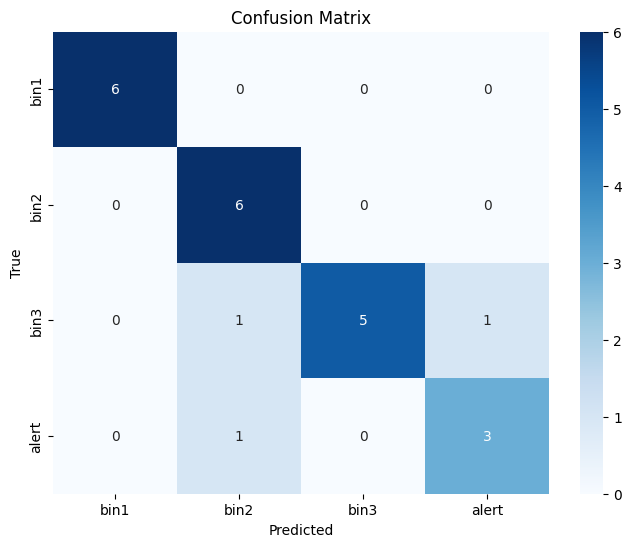

In [27]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['bin1', 'bin2', 'bin3', 'alert'], yticklabels=['bin1', 'bin2', 'bin3', 'alert'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
model_path = '/content/drive/MyDrive/sniff_detection_3.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, model_path)
print(model_path)

/content/drive/MyDrive/sniff_detection_3.pth
